In [9]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

In [10]:
#define some basic functions here, like xcorr and etc

@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


<h1 style="font-size:30pt">Setup</h1>

Start with basic hard-coded stuff (to make config later)

In [14]:

#spectrum interval (aka period) (4096 point FFT, 250M sampling rate)
T_SPECTRA = 4096/250e6

#set integration times for coarse and visibilities (spectra per chunk)
c_acclen = 10**6 
acclen = 30* 10**3 
print(c_acclen, acclen)

#time taken for one full chunk 
T_ACCLEN = acclen*4096/250e6 
#how many total chunks for the time interval we care about
nchunks = int((t_end-t_start)/T_ACCLEN)




#start and end times
start_file_time = 1721800002
t_start = start_file_time + 1000*5  #for easy correlation purposes
t_end = t_start+3600


#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print(files_a1)
print(files_a2)
print("Uncorrected Starting Indices:", idx1, idx2)




#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart 

['/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805062.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805106.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805151.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805195.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805240.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805284.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805328.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805373.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805417.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805462.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805506.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/17218055

Below is where I would run the satellite_detection script, and get both the offset and the pulses, needed for the next step. For now it's bullshit plot armour hand-waving.

In [ ]:
idx_correction=109993-100000
if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)
print("Corrected Starting Indices:", idx1, idx2)

<h1 style="font-size:30pt">Visibility Stuff</h1>

Now, once we have the predicted phase and have the index offset set up, we can find the observed phases. Recall that for now, this is only done for ONE satellite pass. We want to get to at least five passes, so in the streamlined code this will be done recursively.

In [102]:
#set up BaseBandFileIterator objects for both antenna
#this should be with the CORRECTED starting index though.

ant1=bdc.BasebandFileIterator(files_a1, 0, idx1, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2=bdc.BasebandFileIterator(files_a2, 0, idx2, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 30000
took 0.235 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw
START SPECNUM IS 1294978843 obj start at 1293198830
ACCLEN RECEIVED IS 30000


took 1.408 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804989.raw
START SPECNUM IS 1351222502 obj start at 1350429045


In [103]:
#getting visibility

m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(chunk1['pol0'], chunk2['pol0'],chunk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)


took 1.333 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw
took 1.418 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805034.raw
took 1.340 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805062.raw
took 1.433 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805078.raw
took 1.467 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805106.raw
took 1.399 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805123.raw
took 1.361 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805151.raw
took 1.373 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805167.raw
took 1.482 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805195.raw
took 1.468 seconds 

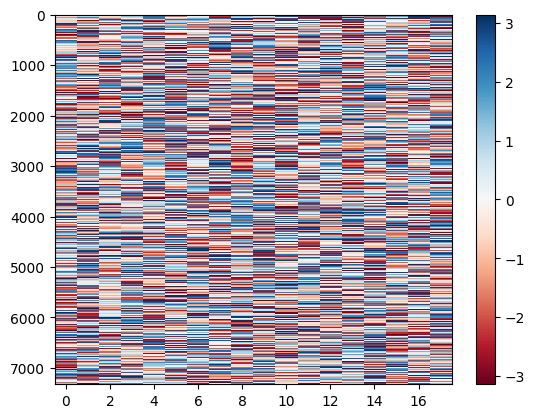

In [104]:
#plot visibility phase for the whole time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

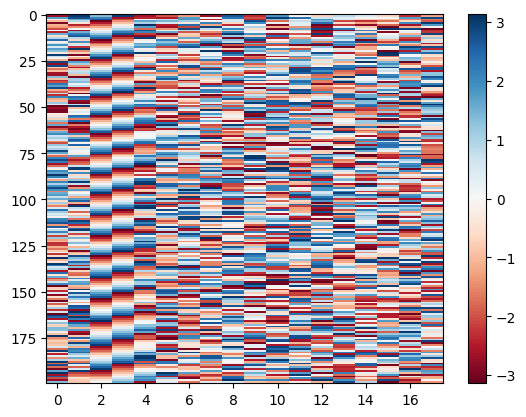

In [105]:
#for part of the time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:200,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

In [106]:
visibility_phased[:5,0]

masked_array(data=[(-0.007566666696220636-0.014433333650231361j),
                   (-0.031433332711458206-0.015233333222568035j),
                   (-0.007266666740179062+0.047066666185855865j),
                   (0.014833333902060986-0.004666666500270367j),
                   (0.01073333341628313-0.01626666635274887j)],
             mask=[False, False, False, False, False],
       fill_value=np.complex128(1e+20+0j),
            dtype=complex64)

In [107]:
t_start+3600*8.5

1721835602.0

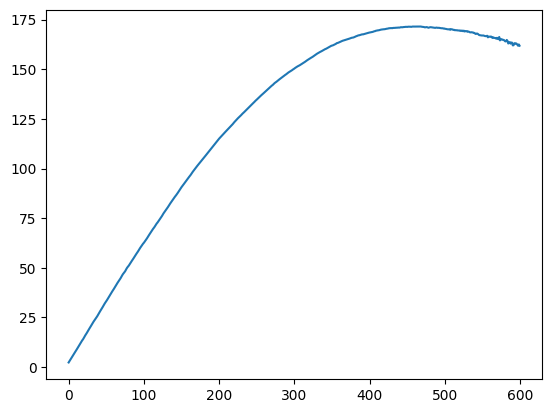

In [108]:
#plot visibility total
plt.plot(np.unwrap(vis_phase[0:600,3]))

In [2]:
1699711132 - 1699625045

86087